# Bitter Melons Regression Model with SARIMA
By Menard Gymer V. Rivera

## Load the Dataset

In [9]:
import pandas as pd

In [10]:
Tilapia_UN = pd.read_excel('./data/bitter_melon_UN.xlsx')

In [11]:
Tilapia_DA = pd.read_excel('./data/bitter_melon_DA.xlsx')

In [12]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,842,Bitter melon - Retail,5,KG,5,2020,70.31
1,842,Bitter melon - Retail,5,KG,5,2020,53.85
2,842,Bitter melon - Retail,5,KG,5,2020,85.00
3,842,Bitter melon - Retail,5,KG,5,2020,62.62
4,842,Bitter melon - Retail,5,KG,5,2020,113.60
...,...,...,...,...,...,...,...
1156,842,Bitter melon - Retail,5,KG,6,2021,70.00
1157,842,Bitter melon - Retail,5,KG,6,2021,65.00
1158,842,Bitter melon - Retail,5,KG,6,2021,64.38
1159,842,Bitter melon - Retail,5,KG,6,2021,106.25


In [13]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,Bitter melon - Retail,NaN,KG,1,2022,105.34
1,NaN,Bitter melon - Retail,NaN,KG,2,2022,103.30
2,NaN,Bitter melon - Retail,NaN,KG,3,2022,102.66
3,NaN,Bitter melon - Retail,NaN,KG,4,2022,96.12
4,NaN,Bitter melon - Retail,NaN,KG,5,2022,97.92


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [14]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [15]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [16]:
Tilapia_UN.head()

,mp_price,date
0,70.31,2020-05-15
1,53.85,2020-05-15
2,85.00,2020-05-15
3,62.62,2020-05-15
4,113.60,2020-05-15


### DA Bantay Presyo

In [17]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [18]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [19]:
Tilapia_DA.head()

,mp_price,date
0,105.34,2022-01-15
1,103.30,2022-02-15
2,102.66,2022-03-15
3,96.12,2022-04-15
4,97.92,2022-05-15


In [20]:
import matplotlib.pyplot as plt

In [21]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

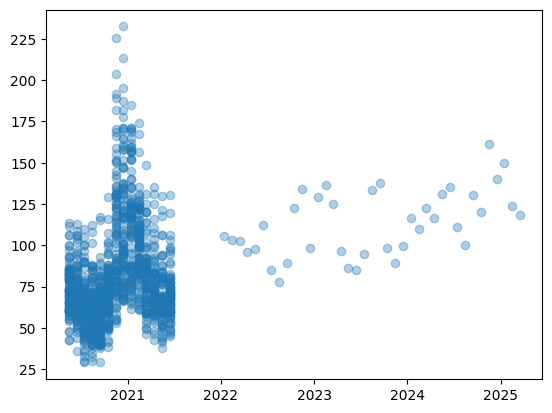

<Figure size 5000x600 with 0 Axes>

In [22]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [23]:
from datetime import datetime

In [24]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [25]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [26]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [27]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

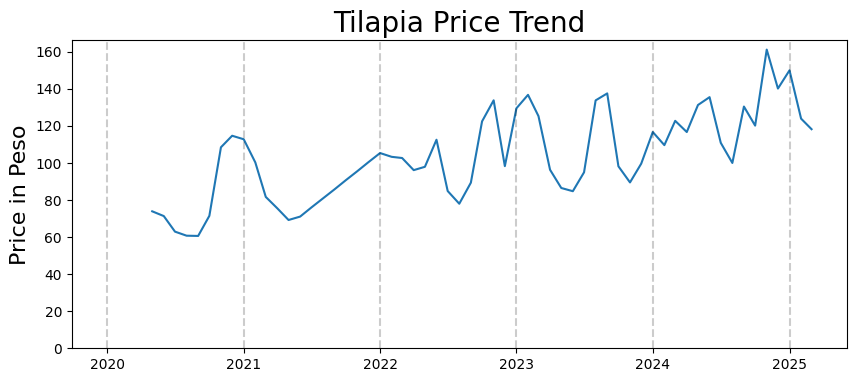

In [28]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [29]:
first_diff = lim_tilapia.diff()[1:]

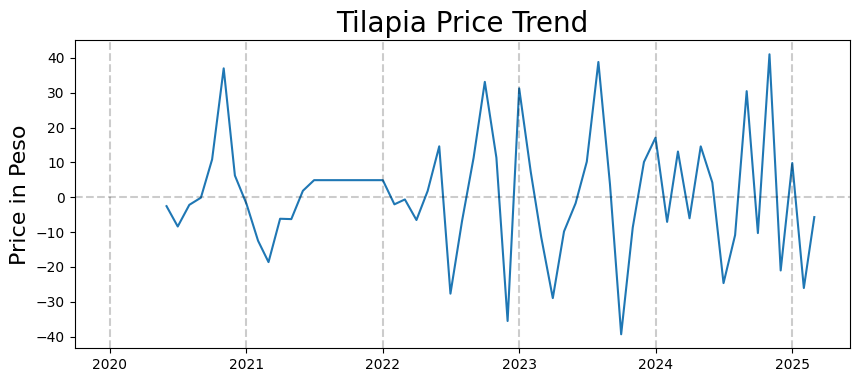

In [30]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [31]:
from statsmodels.tsa.stattools import acf, pacf

<BarContainer object of 18 artists>

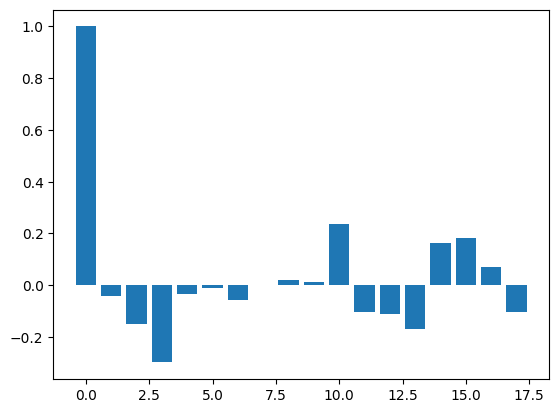

In [32]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

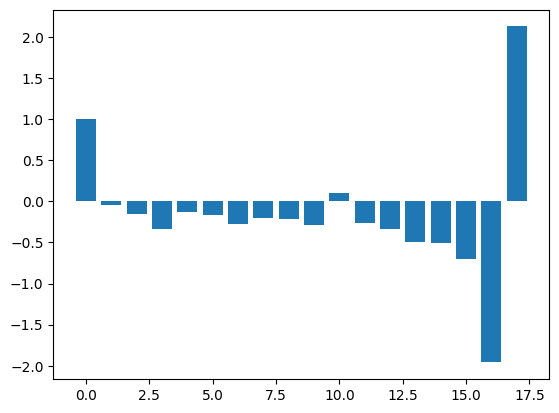

In [33]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [34]:
from datetime import timedelta

In [35]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [36]:
Tilapia.describe()

,mp_price
count,59.000000
mean,103.189504
std,23.811527
min,60.613962
25%,85.300159
50%,100.287149
75%,121.290000
max,161.160000


## Fit the SARIMA Model

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [38]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [39]:
from time import time

In [40]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.7876465320587158


/home/meg/jupyter_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   53
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -217.137
Date:                              Wed, 21 May 2025   AIC                            440.274
Time:                                      08:22:11   BIC                            446.128
Sample:                                  05-01-2020   HQIC                           442.518
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9997      0.745     -1.343      0.179      -2.459       0.460
ma.S.L12       0.98

In [42]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01    120.14
2024-11-01    161.16
2024-12-01    140.14
2025-01-01    149.96
2025-02-01    123.91


In [43]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [44]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [45]:
predictions

date
2024-10-01    141.387051
2024-11-01    148.667155
2024-12-01    142.474711
2025-01-01    143.499783
2025-02-01    144.043448
2025-03-01    138.098351
Freq: MS, Name: predicted_mean, dtype: float64

In [46]:
residuals

date
2024-10-01   -21.247051
2024-11-01    12.492845
2024-12-01    -2.334711
2025-01-01     6.460217
2025-02-01   -20.133448
2025-03-01   -19.888351
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

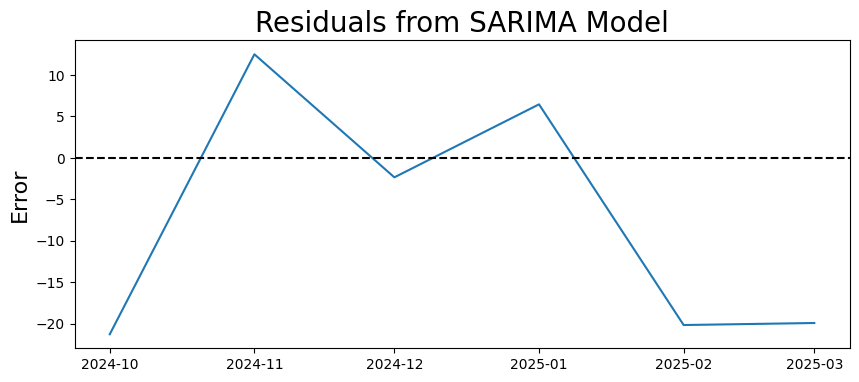

In [47]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

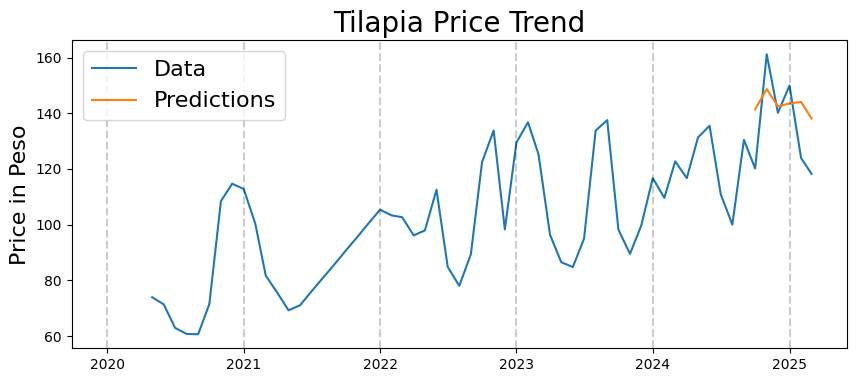

In [48]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [49]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/home/meg/jupyter_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_22355/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/home/meg/jupyter_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_22355/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_22355/2554385675.py:8: FutureWarning: Calling float on a single element Serie

In [50]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

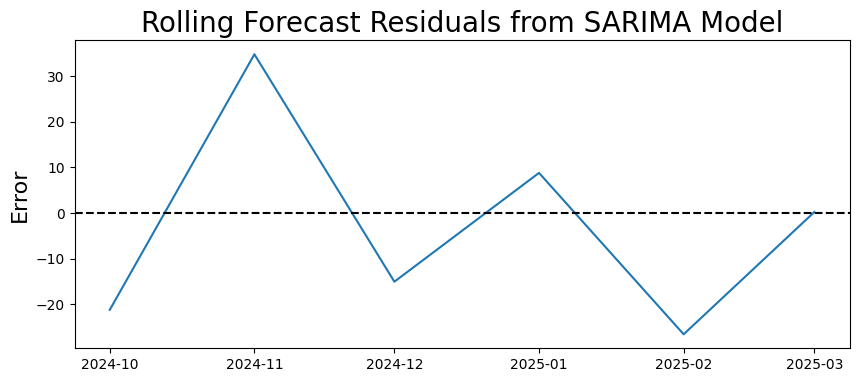

In [51]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

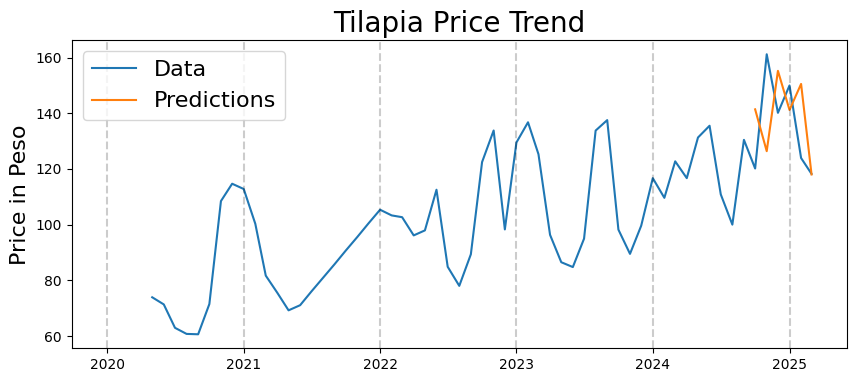

In [52]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [53]:
import numpy as np

In [54]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.1292


In [55]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 21.112204212663734


## Future Predictions (2025)

In [56]:
#get the predictions and residuals
predictions = model_fit.forecast(12)
# predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [57]:
predictions

2025-03-01    118.007768
2025-04-01    114.880479
2025-05-01    110.370044
2025-06-01    108.401469
2025-07-01    117.637122
2025-08-01    125.385477
2025-09-01    121.365048
2025-10-01    113.071679
2025-11-01    101.724777
2025-12-01    109.682531
2026-01-01    107.591554
2026-02-01    110.294183
Freq: MS, Name: predicted_mean, dtype: float64

In [58]:
residuals

2024-10-01         NaN
2024-11-01         NaN
2024-12-01         NaN
2025-01-01         NaN
2025-02-01         NaN
2025-03-01    0.202232
2025-04-01         NaN
2025-05-01         NaN
2025-06-01         NaN
2025-07-01         NaN
2025-08-01         NaN
2025-09-01         NaN
2025-10-01         NaN
2025-11-01         NaN
2025-12-01         NaN
2026-01-01         NaN
2026-02-01         NaN
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

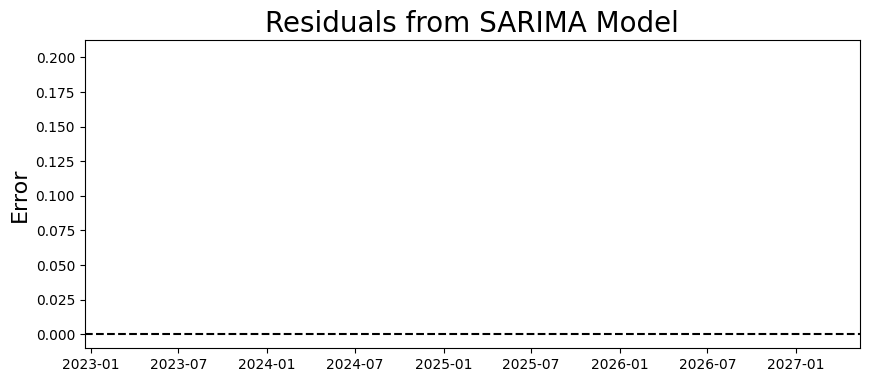

In [59]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

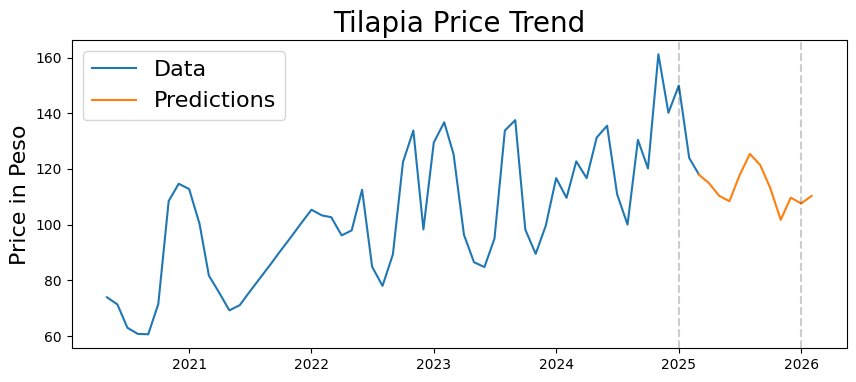

In [60]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(2025,2027):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [61]:
# Tilapia 100g
# Protein = 19g
protein = 19*10
# Carbohydrates = 0g
carbs = 0*10
# Fats = 2.48 g
fats = 2.48*10
# Fiber 0g
fiber = 0*10

In [62]:
protein_projection = protein / predictions

Text(0, 0.5, 'Protein in Grams')

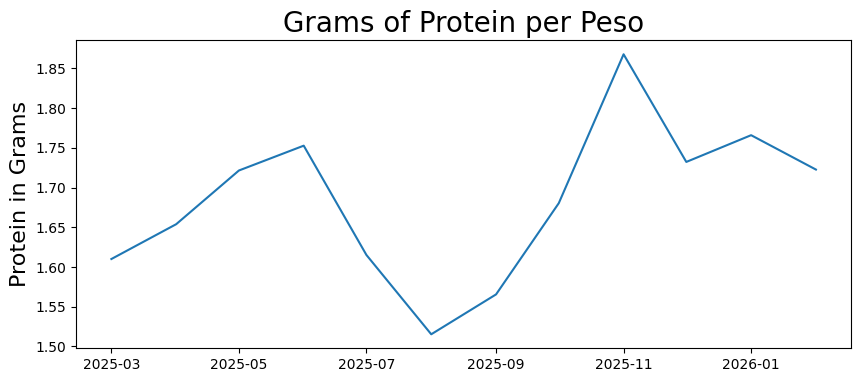

In [63]:
plt.figure(figsize=(10,4))

plt.plot(protein_projection)

plt.title('Grams of Protein per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [64]:
carbs_projection = carbs / predictions

Text(0, 0.5, 'Protein in Grams')

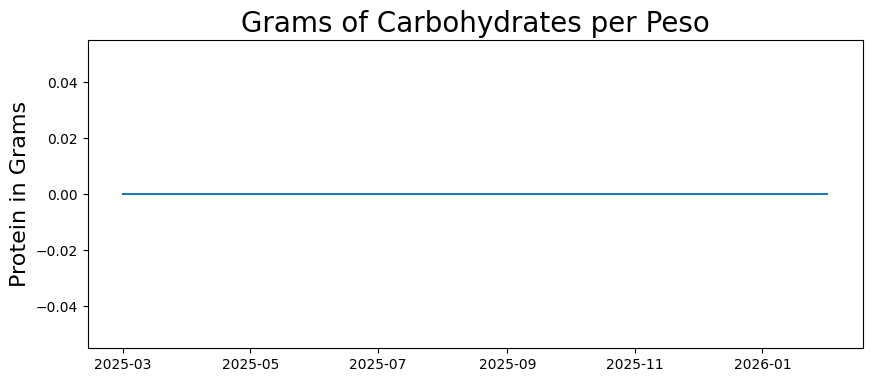

In [65]:
plt.figure(figsize=(10,4))

plt.plot(carbs_projection)

plt.title('Grams of Carbohydrates per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [66]:
fats_projection = fats / predictions

Text(0, 0.5, 'Protein in Grams')

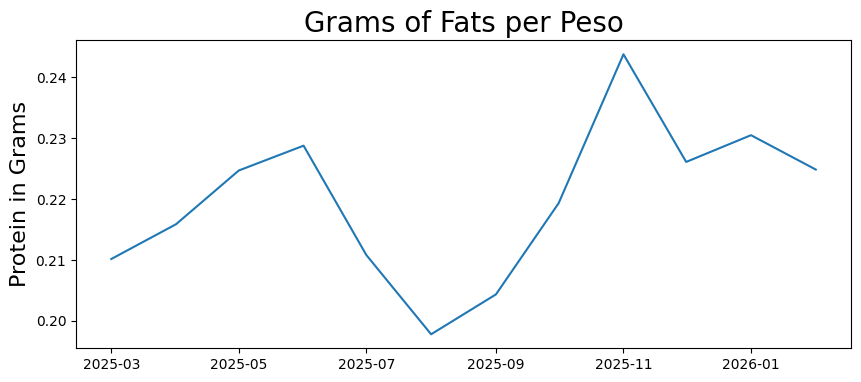

In [67]:
plt.figure(figsize=(10,4))

plt.plot(fats_projection)

plt.title('Grams of Fats per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [68]:
fiber_projection = fiber / predictions

Text(0, 0.5, 'Protein in Grams')

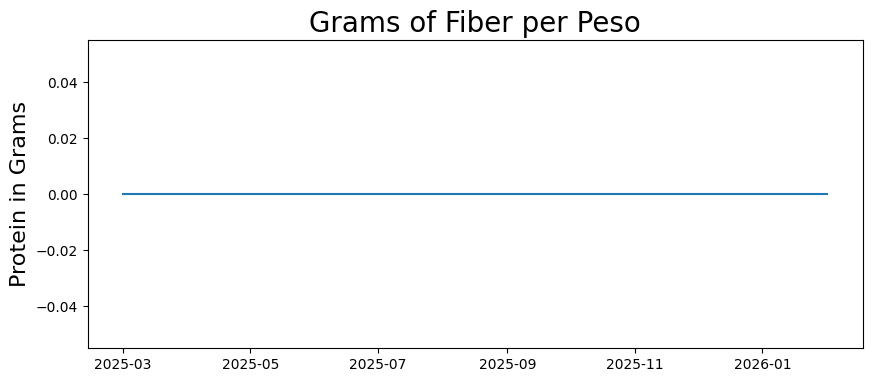

In [69]:
plt.figure(figsize=(10,4))

plt.plot(fiber_projection)

plt.title('Grams of Fiber per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [70]:
protein_projection.to_csv('./protein.csv', index=True)
carbs_projection.to_csv('./carbs.csv', index=True)
fats_projection.to_csv('./fats.csv', index=True)
fiber_projection.to_csv('./fiber.csv', index=True)